In [7]:
# Relevant libraries
import pandas as pd
import scipy.optimize as sc
from sklearn.model_selection import train_test_split
import numpy as np


# Load data from CSV file
file = pd.read_csv("../Output/LowPPMMatrix.csv")
# Extract the columns from the data
#file2=file2[file2['Target PPM']<=500]

file=file[file['Target PPM']!=150]
# Separate the independent and dependent variables
X = file.drop('Target PPM', axis='columns')
y = file.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Funk Equation
# a*R+b
# a*np.exp(-1*R*b+c)+d
# a*R**b+c
# a*R**b+c*H*(a*R**b+c)+d  (Basically Bastviken)
# (a*np.exp(-1*R*b+c)+d)+f*H*(a*np.exp(-1*R*b+c)+d)+g
# a*np.exp(-1*R*b+c)+d*np.exp(-1*H*f+g)+h (Funk Equation)
# a*np.exp((-1*R*b+c)+(-1*H*d+e))+f 4.2
#                                                           W/1000  W/500   UV500   UV1000
# a**((-1*R*b+c)+(-1*H*d+e))+f 6.4                          87.79   42.64   62.74   116.35
# a**((-1*R*b)+(-1*H*c)+d)+e   6.5                          87.79

# a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f 7.1                 74.09   35.76   62.37   113.46


# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+f)+g 8.1
# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1)/(T*f*H**g))*h)+i)+j 8.2
# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i)+j 8.3                           5.764

#a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i)+j*np.exp(-1*T*k)+l 9.1


#0.97**((((-1*R)/(H**(-0.66)))*c)+(-1*H)+(1.21*T)+(((-1.22*T)/(H**0.23))*1.25)+-178.26)+j            5.865



def funkEQ(X, a, b):
    R, H, T = X
    with np.errstate(over='ignore'):
        stuff=0.97**((((-1*R)/(H**(-0.66)))*a)+(-1*H)+(1.21*T)+(((-1.22*T)/(H**0.23))*1.25)+-178.26)+b
    return stuff
p0 = 1,1

def residual(params, X, y):
    return np.sum((y - funkEQ(X, *params))**2)

# Creating a matrix to store all of the variables
coef = []
zeroPPM = []
matchingTemp = []
targetPPM_zero = []
resistance_zero = []
temperature_zero = []
relativeHumidity_zero = []

target_temps = [0, 20, 35]
target_rh = [5, 15, 30, 45, 60]
range_width = 3
rh_range = 5

unique_sensors = file['SensorID'].unique()

for s in unique_sensors:
    file2 = file[file['SensorID'] == s]
    xDataResistance = file2.loc[:, 'Resistance']
    xDataRH = file2.loc[:, 'RelativeHumidity']
    xDataTemp = file2.loc[:, 'Temperature']
    yDataTargetPPM = file2.loc[:, 'Target PPM']

    for temp in target_temps:
        for rh in target_rh:
            selected_rows = file2[
                (file2['Temperature'] >= (temp - range_width)) &
                (file2['Temperature'] <= (temp + range_width)) &
                (file2['RelativeHumidity'] >= (rh - rh_range)) &
                (file2['RelativeHumidity'] <= (rh + rh_range))
                ]

            popt, pcov = sc.curve_fit(funkEQ, (xDataResistance, xDataRH, xDataTemp), yDataTargetPPM, maxfev=1000000)

            zero_ppm_data = selected_rows[selected_rows['Target PPM'] == 0]

            if not zero_ppm_data.empty:
                avg_temp = selected_rows['Temperature'].mean()
                avg_rh = zero_ppm_data['RelativeHumidity'].mean()

                matchingTemp.append(avg_temp)
                coef.append(popt)
                resistance_at_zero = zero_ppm_data['Resistance'].values[0]
                zeroPPM.append(float(resistance_at_zero))

                targetPPM_zero.append(0)
                resistance_zero.append(float(resistance_at_zero))
                temperature_zero.append(float(avg_temp))
                relativeHumidity_zero.append(float(avg_rh))
# Create a DataFrame
coef1 = [row[0] for row in coef]
coef2 = [row[1] for row in coef]
df_combined = pd.DataFrame({
    'Coef1': coef1,
    'Resistance': resistance_zero,
    'Temperature': temperature_zero,
    'RelativeHumidity': relativeHumidity_zero
})

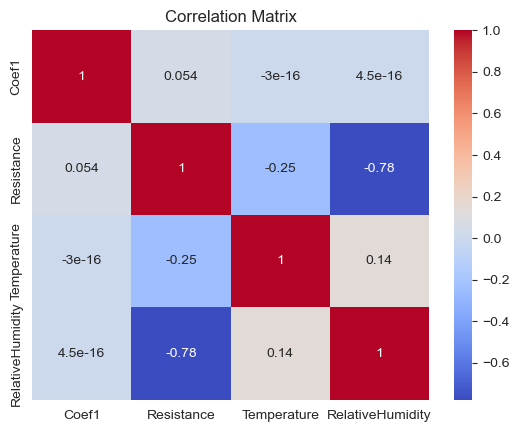

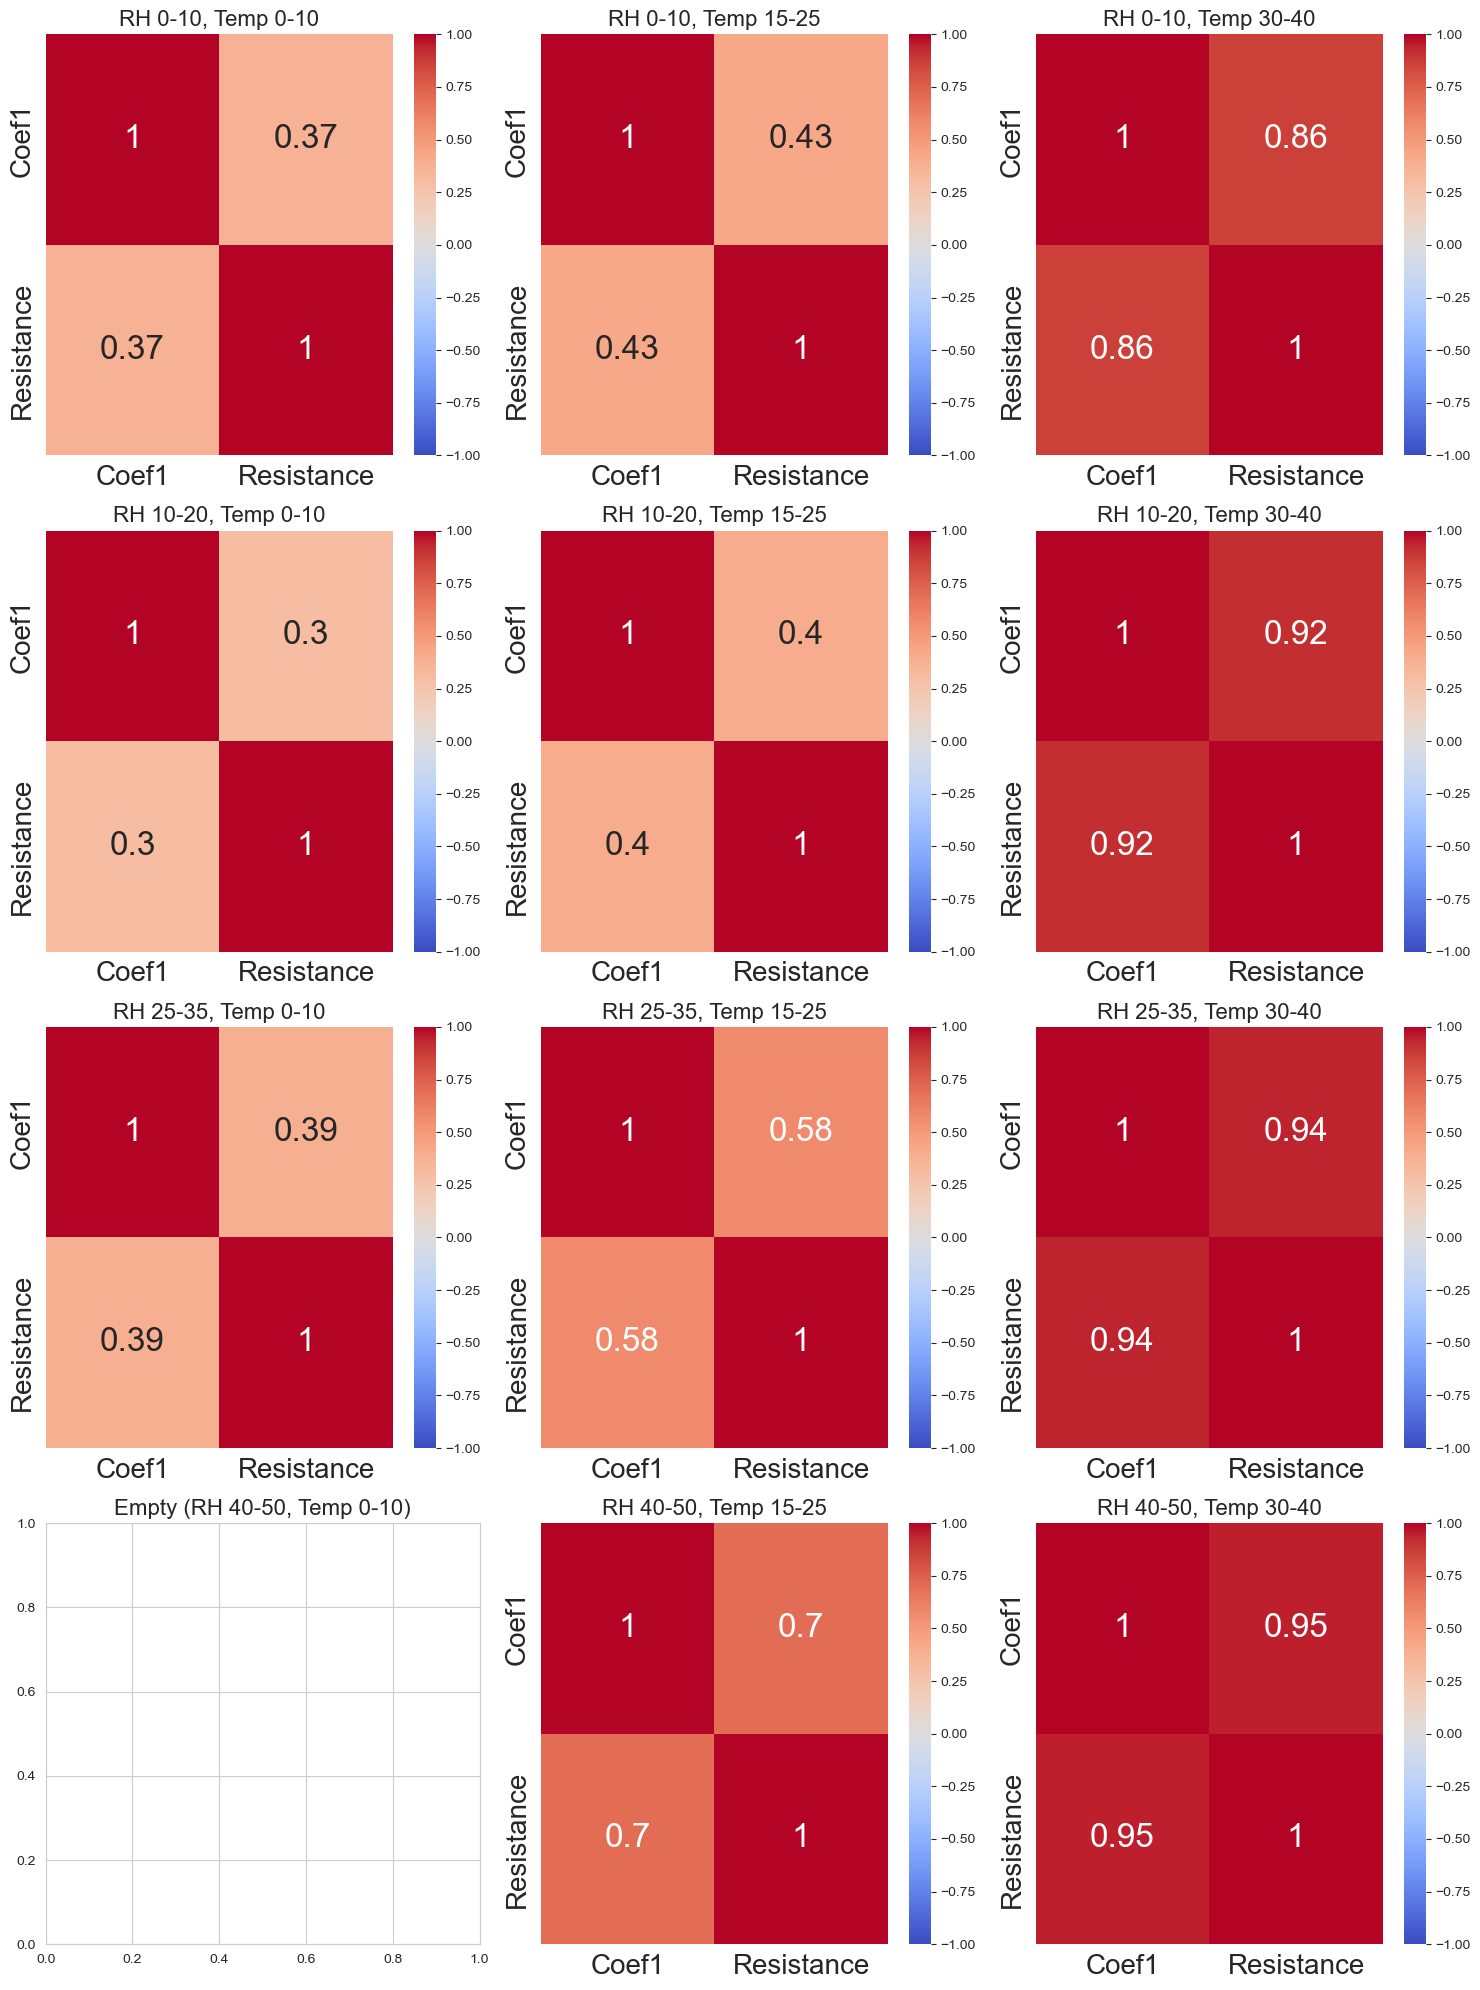

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix

corr_matrix = df_combined.corr()

# Generate a heatmap using Seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Define the relative humidity ranges
rh_ranges = [(0, 10),(10,20), (25, 35), (40, 50)]
temp_ranges = [(0, 10), (15, 25), (30, 40)]

# Create a 4x3 grid for subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Loop over each relative humidity and temperature range
for i, (rh_min, rh_max) in enumerate(rh_ranges):
    for j, (temp_min, temp_max) in enumerate(temp_ranges):
        ax = axes[i, j]

        # Filter data based on humidity and temperature ranges
        subset = df_combined[(df_combined['RelativeHumidity'] >= rh_min) &
                             (df_combined['RelativeHumidity'] <= rh_max) &
                             (df_combined['Temperature'] >= temp_min) &
                             (df_combined['Temperature'] <= temp_max)]

        # Drop 'Temperature' and 'RelativeHumidity' from the subset
        subset_dropped = subset.drop(['Temperature', 'RelativeHumidity'], axis=1)

        # Skip if the subset is empty
        if subset.empty:
            ax.set_title(f'Empty (RH {rh_min}-{rh_max}, Temp {temp_min}-{temp_max})',fontsize=16)
            continue

        # Compute the correlation matrix within this subset
        corr_matrix = subset_dropped.corr()

        # Generate a heatmap using Seaborn on the current subplot axis
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax, annot_kws={"size": 24}, vmin=-1, vmax=1)

        # Increase the size of axis tick labels
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title(f'RH {rh_min}-{rh_max}, Temp {temp_min}-{temp_max}',fontsize=16)

plt.tight_layout()
plt.show()

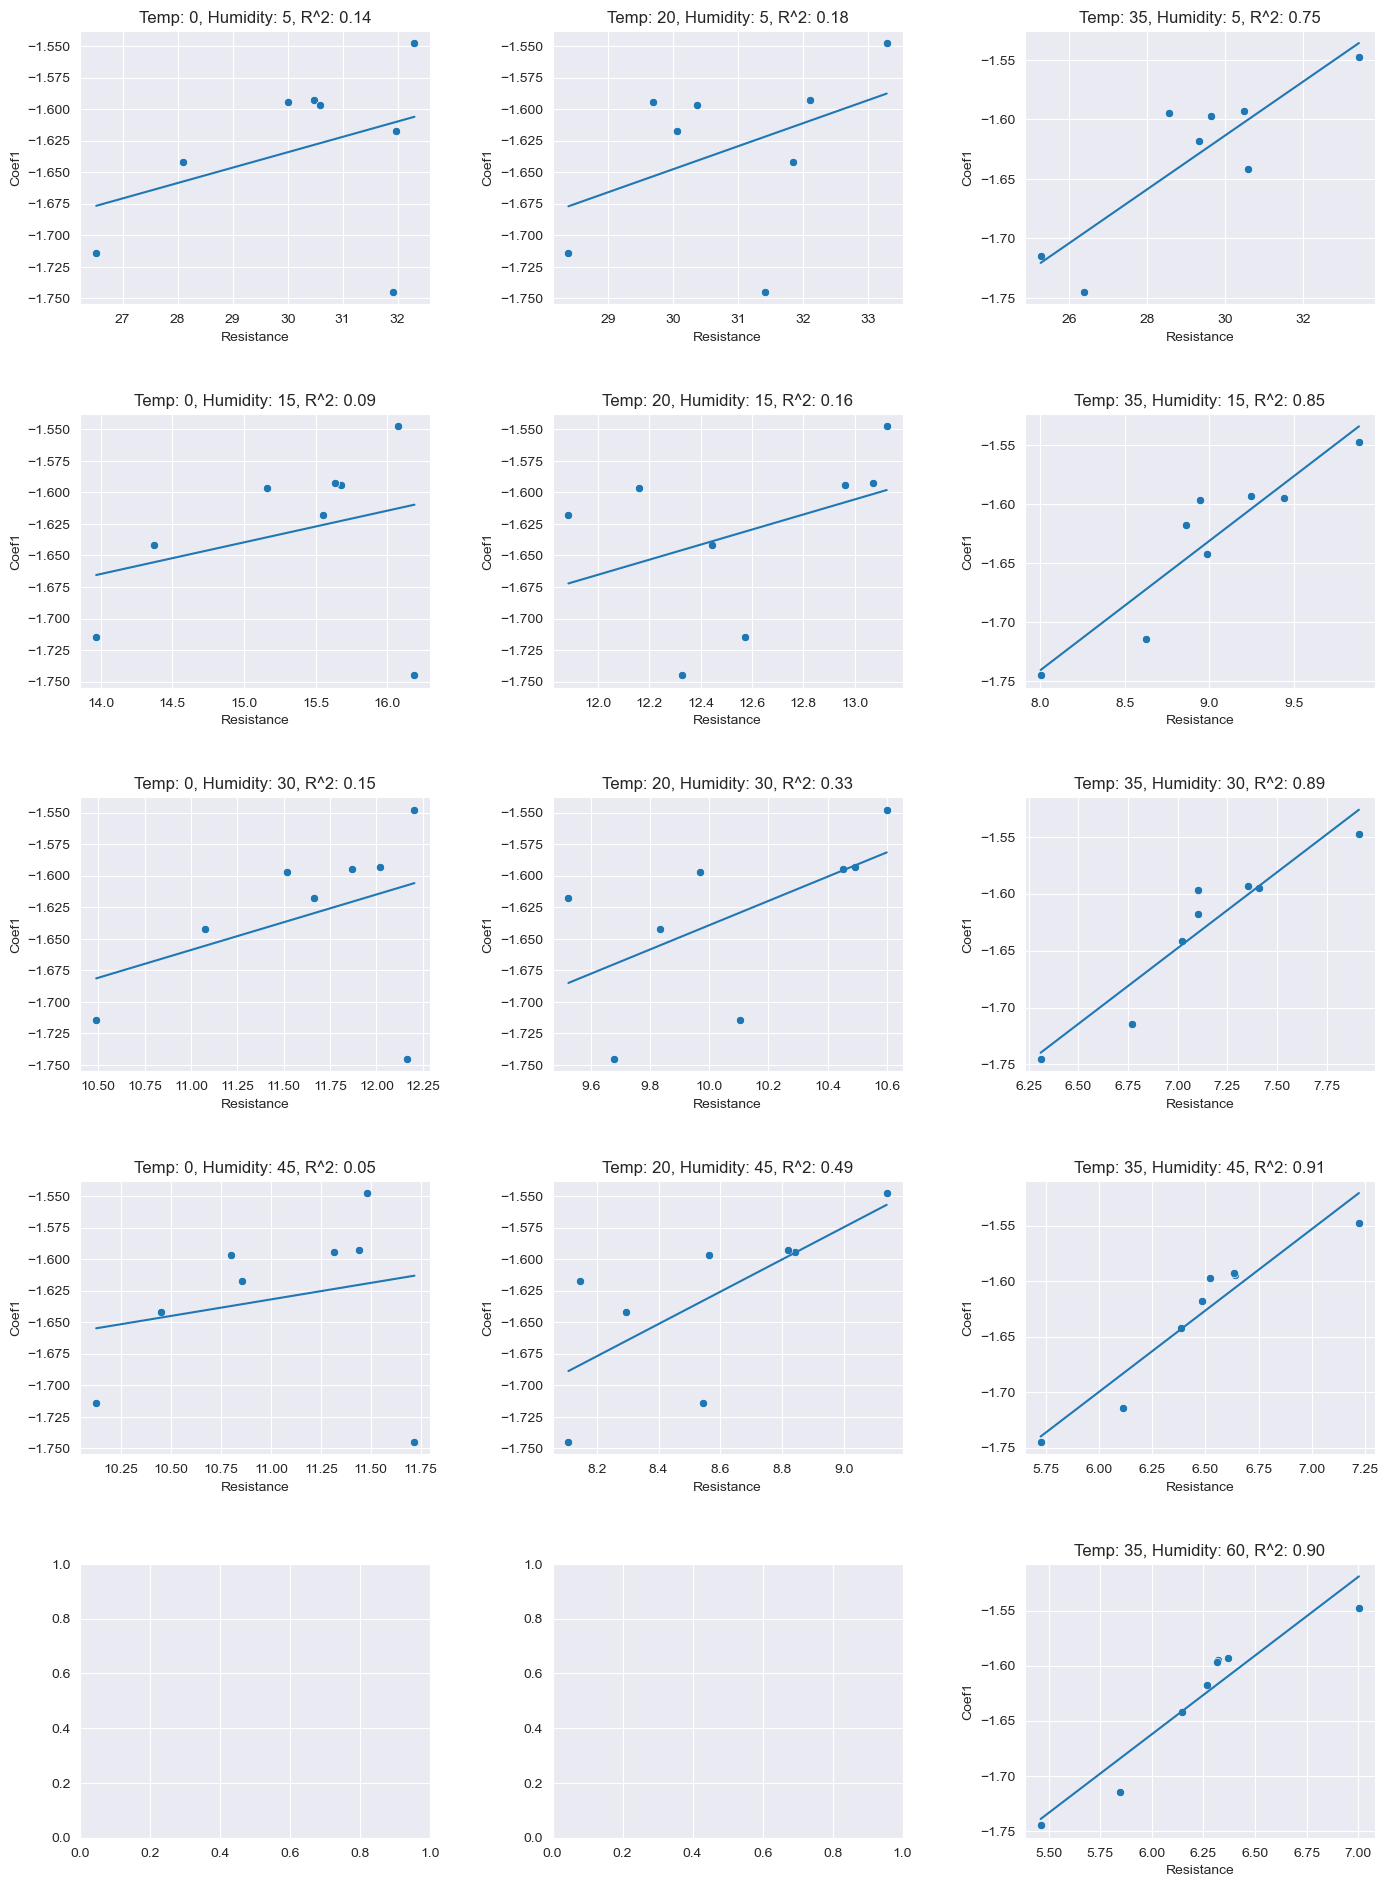

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
target_temps = [0, 20, 35]
target_humidities = [5, 15, 30, 45, 60]
range_width = 5

# Create a 5x3 grid for plots
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
plt.tight_layout(pad=6)

for i, humidity in enumerate(target_humidities):
    for j, temp in enumerate(target_temps):
        # Filter data
        filtered_df = df_combined[
            (df_combined['Temperature'] >= temp - range_width) &
            (df_combined['Temperature'] <= temp + range_width) &
            (df_combined['RelativeHumidity'] >= humidity - range_width) &
            (df_combined['RelativeHumidity'] <= humidity + range_width)
            ]

        if not filtered_df.empty:
            X = filtered_df[['Resistance']]
            y = filtered_df['Coef1']

            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            r2 = r2_score(y, y_pred)

            ax = axes[i, j]
            sns.scatterplot(x='Resistance', y='Coef1', data=filtered_df, ax=ax)
            sns.lineplot(x=filtered_df['Resistance'], y=y_pred, ax=ax)

            ax.set_title(f"Temp: {temp}, Humidity: {humidity}, R^2: {r2:.2f}")